In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import glob
import geopandas
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from shapely import geometry
from datetime import datetime

In [2]:
hs_df = geopandas.GeoDataFrame()

In [3]:
for file in glob.glob('../../data/processed/ML_singlesat_2km_hotspot_grid_20190[4,9]*.geojson'):
    temp_df = geopandas.read_file(file)
    datestring = file[-16:-8]
    temp_df['sat_date'] = datetime.strptime(datestring, "%Y%m%d").strftime("%Y/%m/%d")
    hs_df = hs_df.append(temp_df)

In [4]:
#change projection to mercator
hs_df.crs = {'init': 'epsg:3857'}
hs_df.reset_index(inplace=True) 
#assign unique id to each grid 
hs_df['id_grid'] = hs_df.index

C:\Anaconda3\envs\fred_linux\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
#read in AOI shp file and reproject to mercator
clip_area = geopandas.read_file('../../references/ground_truth/shapefile/aoi.shp')
clip_area.crs
clip_area = clip_area.to_crs({'init': 'epsg:3857'})

In [6]:
hs_df.drop(columns=['index'], inplace=True)

In [7]:
hs_df

,polar_weight,geo_weight,weight,terra_weight,aqua_weight,n20_weight,npp_weight,geometry,sat_date,id_grid
0,0.1675,0.0,0.08375,0.0,0.00,0.67,0.0,"POLYGON ((10761976.873 2968804.526, 10763976.8...",2019/04/01,0
1,0.1675,0.0,0.08375,0.0,0.00,0.67,0.0,"POLYGON ((10761976.873 2966804.526, 10763976.8...",2019/04/01,1
2,0.2000,0.0,0.10000,0.0,0.00,0.80,0.0,"POLYGON ((10761976.873 2958804.526, 10763976.8...",2019/04/01,2
3,0.3450,0.0,0.17250,0.0,0.00,1.38,0.0,"POLYGON ((10745976.873 2954804.526, 10747976.8...",2019/04/01,3
4,0.1575,0.0,0.07875,0.0,0.00,0.63,0.0,"POLYGON ((10747976.873 2954804.526, 10749976.8...",2019/04/01,4
...,...,...,...,...,...,...,...,...,...,...
1058778,0.1625,0.0,0.08125,0.0,0.00,0.65,0.0,"POLYGON ((13405976.873 -1133195.474, 13407976....",2019/09/30,1058778
1058779,0.1175,0.0,0.05875,0.0,0.47,0.00,0.0,"POLYGON ((13373976.873 -1135195.474, 13375976....",2019/09/30,1058779
1058780,0.1675,0.0,0.08375,0.0,0.00,0.67,0.0,"POLYGON ((13797976.873 -1137195.474, 13799976....",2019/09/30,1058780
1058781,0.1675,0.0,0.08375,0.0,0.00,0.67,0.0,"POLYGON ((13799976.873 -1137195.474, 13801976....",2019/09/30,1058781


In [8]:
#load in ground truth data
truth_df = pd.read_csv('../../references/ground_truth/processed/daily_ground_truth_Apr_Sep_2019.csv')
truth_df.drop(columns=["Unnamed: 0"], inplace=True)

In [9]:
truth_gdf = geopandas.GeoDataFrame(truth_df, geometry=geopandas.points_from_xy(truth_df.lon, truth_df.lat))

In [10]:
#reproject to mercator
truth_gdf.crs = {'init' :'epsg:4326'}
truth_gdf = truth_gdf.to_crs({'init': 'epsg:3857'})

C:\Anaconda3\envs\fred_linux\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
#add in 1 km buffer
truth_gdf_buffered = truth_gdf.buffer(1000)
#add in 500 m buffer
#truth_gdf_buffered = truth_gdf.buffer(500)
#no buffer
#truth_gdf_buffered = truth_gdf.buffer(1)
truth_gdf.geometry = truth_gdf_buffered

In [12]:
#clip and remove hotspot grid outside of aoi
hs_df_clipped = geopandas.overlay(clip_area, hs_df, how='intersection')

In [13]:
hs_df_clipped.to_file('../../data/interim/multisat_singlesat_grid_hotspot_1m_clipped_apr_sep_2019.geojson', driver='GeoJSON')

In [14]:
#remove `id` of the aoi shp file
hs_df_clipped.drop(columns=['id'], inplace=True)
hs_df_clipped.head()

,polar_weight,geo_weight,weight,terra_weight,aqua_weight,n20_weight,npp_weight,sat_date,id_grid,geometry
0,0.0,0.000240,0.000120,0.0,0.0,0.0,0.0,2019/09/20,959695,"POLYGON ((11321976.873 84804.526, 11323976.873..."
1,0.0,0.000240,0.000120,0.0,0.0,0.0,0.0,2019/09/20,959694,"POLYGON ((11321090.741 82804.526, 11321100.893..."
2,0.0,0.000119,0.000060,0.0,0.0,0.0,0.0,2019/09/20,959578,"POLYGON ((11321100.893 84804.526, 11321111.045..."
3,0.0,0.000047,0.000023,0.0,0.0,0.0,0.0,2019/09/21,971133,"POLYGON ((11321976.873 86804.526, 11323976.873..."
4,0.0,0.000291,0.000145,0.0,0.0,0.0,0.0,2019/09/17,922578,"POLYGON ((11321976.873 86804.526, 11323976.873..."


In [15]:
#assign unique id for the id of the ground truth data
truth_gdf['id_truth'] = truth_gdf.index
truth_gdf.head()

,datestamp,geometry,lat,lon,end_date,start_date,period,id_truth
0,2019/09/01,"POLYGON ((11372379.424 47734.603, 11372374.609...",0.428803,102.150839,2019-09-01,2019-09-01,0 days 00:00:00.000000000,0
1,2019/09/01,"POLYGON ((11372513.189 47386.805, 11372508.374...",0.425679,102.152041,2019-09-01,2019-09-01,0 days 00:00:00.000000000,1
2,2019/09/01,"POLYGON ((11400898.079 -14065.191, 11400893.26...",-0.126350,102.407027,2019-09-01,2019-09-01,0 days 00:00:00.000000000,2
3,2019/09/01,"POLYGON ((11400068.738 -13984.932, 11400063.92...",-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000,3
4,2019/09/01,"POLYGON ((11401433.139 -14038.438, 11401428.32...",-0.126109,102.411833,2019-09-01,2019-09-01,0 days 00:00:00.000000000,4


In [16]:
#overlay both groundtruth and hotspot grid data
overlaid_gdf_ungrp = geopandas.overlay(truth_gdf, hs_df_clipped, how='union')

In [17]:
overlaid_gdf_ungrp.head()

,datestamp,lat,lon,end_date,start_date,period,id_truth,polar_weight,geo_weight,weight,terra_weight,aqua_weight,n20_weight,npp_weight,sat_date,id_grid,geometry
0,2019/09/01,0.428803,102.150839,2019-09-01,2019-09-01,0 days 00:00:00.000000000,0.0,0.1600,0.0,0.08000,0.0,0.0,0.0,0.64,2019/09/06,741529.0,"POLYGON ((11371976.873 46934.193, 11371934.994..."
1,2019/09/01,0.425679,102.152041,2019-09-01,2019-09-01,0 days 00:00:00.000000000,1.0,0.1600,0.0,0.08000,0.0,0.0,0.0,0.64,2019/09/06,741529.0,"POLYGON ((11370701.528 46804.526, 11370681.719..."
2,2019/09/06,0.431699,102.150261,2019-09-06,2019-09-06,0 days 00:00:00.000000000,1107.0,0.1600,0.0,0.08000,0.0,0.0,0.0,0.64,2019/09/06,741529.0,"POLYGON ((11371976.873 47308.824, 11371949.409..."
3,2019/09/08,0.430448,102.153402,2019-09-08,2019-09-08,0 days 00:00:00.000000000,1298.0,0.1600,0.0,0.08000,0.0,0.0,0.0,0.64,2019/09/06,741529.0,"POLYGON ((11371976.873 46968.628, 11371955.024..."
4,2019/09/01,0.428803,102.150839,2019-09-01,2019-09-01,0 days 00:00:00.000000000,0.0,0.1375,0.0,0.06875,0.0,0.0,0.0,0.55,2019/09/12,856764.0,"POLYGON ((11371976.873 46934.193, 11371934.994..."


In [18]:
overlaid_gdf_ungrp.to_file('../../data/interim/multisat_singlesat_grid_apr_sep_2019_hs_1m_clipped_gtruth_union.geojson', driver='GeoJSON')

In [19]:
overlaid_gdf_ungrp = geopandas.read_file('../../data/interim/multisat_singlesat_grid_apr_sep_2019_hs_1m_clipped_gtruth_union.geojson')

In [20]:
#check if ground truth date is valid
overlaid_gdf_ungrp['datestamp'].unique()

array(['2019-09-01', '2019-09-06', '2019-09-08', '2019-09-05',
       '2019-09-07', '2019-09-09', '2019-09-18', '2019-09-17',
       '2019-09-22', '2019-09-02', '2019-09-03', '2019-09-10',
       '2019-09-21', '2019-09-16', '2019-09-11', '2019-09-30',
       '2019-09-23', '2019-09-20', '2019-09-19', '2019-09-04',
       '2019-09-25', '2019-09-27', '2019-09-12', '2019-09-26',
       '2019-09-15', '2019-09-14', '2019-09-24', '2019-09-29',
       '2019-09-28', '2019-09-13', '2019-04-02', '2019-04-03',
       '2019-04-12', '2019-04-07', '2019-04-01', '2019-04-04',
       '2019-04-24', '2019-04-05', '2019-04-08', '2019-04-22',
       '2019-04-06', '2019-04-15', '2019-04-16', '2019-04-17',
       '2019-04-23', '2019-04-28', '2019-04-10', '2019-04-18',
       '2019-04-25', '2019-04-09', '2019-04-21', '2019-04-14',
       '2019-04-19', '2019-04-11', '2019-04-20', '2019-04-30',
       '2019-04-13', '2019-04-26', '2019-04-29', '2019-04-27', None],
      dtype=object)

In [21]:
#check if hotspot grid date is valid
overlaid_gdf_ungrp['sat_date'].unique()

array(['2019-09-06', '2019-09-12', '2019-09-08', '2019-09-01',
       '2019-09-02', '2019-09-21', '2019-09-03', '2019-09-07',
       '2019-09-09', '2019-09-05', '2019-09-11', '2019-09-04',
       '2019-09-26', '2019-09-13', '2019-04-07', '2019-09-10',
       '2019-09-18', '2019-09-20', '2019-09-23', '2019-09-17',
       '2019-09-27', '2019-09-22', '2019-09-15', '2019-09-16',
       '2019-09-14', '2019-09-19', '2019-04-29', '2019-09-25',
       '2019-09-30', '2019-09-28', '2019-09-24', '2019-09-29',
       '2019-04-06', '2019-04-10', '2019-04-09', '2019-04-08',
       '2019-04-01', '2019-04-21', '2019-04-18', '2019-04-14',
       '2019-04-15', '2019-04-12', '2019-04-19', '2019-04-04',
       '2019-04-03', '2019-04-05', '2019-04-16', '2019-04-23',
       '2019-04-22', '2019-04-13', '2019-04-17', '2019-04-26',
       '2019-04-20', '2019-04-28', '2019-04-30', '2019-04-02',
       '2019-04-25', '2019-04-24', '2019-04-11', '2019-04-27', None],
      dtype=object)

In [22]:
#initialize with nan
overlaid_gdf_ungrp['truth_flag'] = np.nan

In [23]:
#remove data points if date of detected hs is not the same as date of ground truth data
filter_valid_union = overlaid_gdf_ungrp['sat_date'].notna() & overlaid_gdf_ungrp['datestamp'].notna()
filter_same_date = overlaid_gdf_ungrp['sat_date'] == overlaid_gdf_ungrp['datestamp']
combined_gdf_clean = overlaid_gdf_ungrp.drop(overlaid_gdf_ungrp[filter_valid_union & (~filter_same_date)].index, axis=0)

In [24]:
#set flag of label coinciding hotspots with same date to 1
combined_gdf_clean.loc[combined_gdf_clean['sat_date'] == combined_gdf_clean['datestamp'], 'truth_flag'] = 1
#Set to -1 for missed detections
combined_gdf_clean.loc[combined_gdf_clean['id_grid'].isna(), 'truth_flag'] = -1
#Set to 0 for false alarm
combined_gdf_clean.loc[combined_gdf_clean['id_truth'].isna(), 'truth_flag'] = 0

In [25]:
#get hits and false alarm, avoid double counting of hits (only count as one hit even if hs coincides with multiple ground truth)
#this however will kick away all the missed detections
combined_gdf_clean_hits_falsealarms = combined_gdf_clean.drop_duplicates(subset=['id_grid'], keep='first')

In [26]:
combined_gdf_clean_hits_falsealarms = combined_gdf_clean_hits_falsealarms.loc[~combined_gdf_clean['id_grid'].isna()]

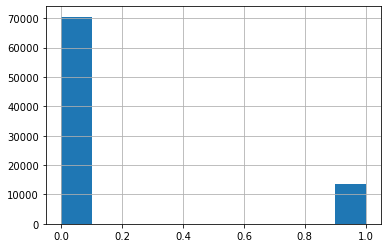

In [27]:
combined_gdf_clean_hits_falsealarms['truth_flag'].hist()

In [28]:
#If a ground truth data has been identified as a hit, it shouldn't be considered as a missed detection anymore. 
#special handling due to union operation, get the list of ground truth data which has been identified as a hit
hits_id_truth_list = combined_gdf_clean_hits_falsealarms.loc[combined_gdf_clean_hits_falsealarms['truth_flag'] == 1, 'id_truth'].unique()

In [29]:
#get missed detections
combined_gdf_clean_missed_detections = combined_gdf_clean[combined_gdf_clean['id_grid'].isna()].copy()
#remove redundant ground truth data misidentified as missed detections
combined_gdf_clean_missed_detections = combined_gdf_clean_missed_detections[~combined_gdf_clean_missed_detections['id_truth'].isin(hits_id_truth_list)].copy()

In [30]:
combined_gdf_clean_dup_removed = pd.concat([combined_gdf_clean_hits_falsealarms, combined_gdf_clean_missed_detections]).drop_duplicates()

In [31]:
#check if double count missed detection or not
try:
    assert combined_gdf_clean_dup_removed.loc[combined_gdf_clean_dup_removed['id_grid'].isna()].duplicated(subset=['id_truth'], keep=False).sum() == 0.0
    print ('Data is clean. No double counting of missed detections.')
except:
    print ('There are duplicated records!')

Data is clean. No double counting of missed detections.


In [32]:
#check if there are no misclassified missed detections
try:
    assert combined_gdf_clean_dup_removed.loc[combined_gdf_clean_dup_removed['id_truth'].isin(hits_id_truth_list), 'id_grid'].isna().sum() == 0.0
    print ('Data is clean. No misclassified missed detections.')
except:
    print ('There are duplicated records!')

Data is clean. No misclassified missed detections.


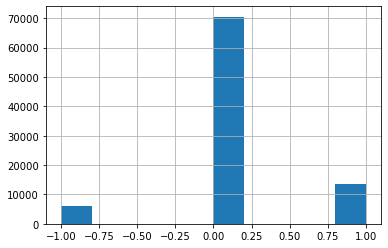

In [33]:
combined_gdf_clean_dup_removed['truth_flag'].hist()

In [34]:
combined_gdf_clean_dup_removed.to_file('../../data/interim/multisat_singlesat_grid_1m_buffer_apr_sep_2019_clean.geojson', driver='GeoJSON')